# STOFS 2D

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/asascience-open/xarray-subset-grid/blob/main/docs/examples/stofs_2d.ipynb)

We use the Stofs-2d-Global Fields-CWL dataset to compute a subset selector and reuse it

In [ ]:
# Install required libraries
# !pip install -q xarray_subset_grid@git+https://github.com/asascience-open/xarray-subset-grid.git
# !pip install -q s3fs cftime xarray cf-xarray fsspec dask h5netcdf

In [2]:
import cf_xarray #noqa
import fsspec
import numpy as np
import xarray as xr

import xarray_subset_grid

# Open the dataset from NODD s3 bucket directly
fs = fsspec.filesystem("s3", anon=True)
ds_cwl = xr.open_dataset(
    fs.open(
        "s3://noaa-gestofs-pds/stofs_2d_glo.20240807/stofs_2d_glo.t06z.fields.cwl.nc"
    ),
    chunks={},
    drop_variables=['nvel']
)

ds_cwl

<xarray.Dataset> Size: 20GB
Dimensions:      (time: 186, node: 12785004, nele: 24875336, nvertex: 3,
                  mesh: 1, nbou: 262, nvel: 12421)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-08-07T01:00:00 ... 2024-08-14...
    x            (node) float64 102MB dask.array<chunksize=(511401,), meta=np.ndarray>
    y            (node) float64 102MB dask.array<chunksize=(511401,), meta=np.ndarray>
Dimensions without coordinates: node, nele, nvertex, mesh, nbou, nvel
Data variables:
    element      (nele, nvertex) int32 299MB dask.array<chunksize=(2763927, 1), meta=np.ndarray>
    adcirc_mesh  (mesh) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    nvell        (nbou) int32 1kB dask.array<chunksize=(262,), meta=np.ndarray>
    max_nvell    int32 4B ...
    ibtype       (nbou) int32 1kB dask.array<chunksize=(262,), meta=np.ndarray>
    nbvv         (nvel) int32 50kB dask.array<chunksize=(12421,), meta=np.ndarray>
    depth        (node) float64 102MB dask.array<chunksize=(511401,), meta=np.ndarray>
    zeta         (time, node) float64 19GB dask.array<chunksize=(1, 511401), meta=np.ndarray>
Attributes: (12/50)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024080706 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

Make the dataset CF compliant

In [3]:
ds_cwl = xarray_subset_grid.grids.ugrid.assign_ugrid_topology(ds_cwl)

In [4]:
f"Dataset size: {ds_cwl.nbytes * 1.0e-9} Gb"

'Dataset size: 19.629483356 Gb'

### Example BBOX

Drawn with https://geojson.io

![image.png](example_data/image.png)

Compute the subset selector.  
Specify the selector name for easier accessibility. (optional)

In [5]:
%%time

bbox = (-70, 40, -60, 50)
name = 'northeastUSA2d'

bbox_selector = ds_cwl.xsg.grid.compute_bbox_subset_selector(ds_cwl, bbox, name)
bbox_selector

CPU times: user 17.6 s, sys: 1.92 s, total: 19.5 s
Wall time: 58.3 s


<class 'xarray_subset_grid.grids.ugrid.UGridSelector'> - northeastUSA2d

Use the subset selector to slice the dataset. This is fast because the computation is already done

In [6]:
%%time

ds_subset_cwl = bbox_selector.select(ds_cwl)
ds_subset_cwl

CPU times: user 255 ms, sys: 0 ns, total: 255 ms
Wall time: 253 ms


<xarray.Dataset> Size: 547MB
Dimensions:      (time: 186, node: 356230, nele: 686355, nvertex: 3, mesh: 1,
                  nbou: 262, nvel: 12421)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-08-07T01:00:00 ... 2024-08-14...
    x            (node) float64 3MB dask.array<chunksize=(79,), meta=np.ndarray>
    y            (node) float64 3MB dask.array<chunksize=(79,), meta=np.ndarray>
Dimensions without coordinates: node, nele, nvertex, mesh, nbou, nvel
Data variables:
    element      (nele, nvertex) int32 8MB dask.array<chunksize=(44090, 1), meta=np.ndarray>
    adcirc_mesh  (mesh) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    nvell        (nbou) int32 1kB dask.array<chunksize=(262,), meta=np.ndarray>
    max_nvell    int32 4B ...
    ibtype       (nbou) int32 1kB dask.array<chunksize=(262,), meta=np.ndarray>
    nbvv         (nvel) int32 50kB dask.array<chunksize=(12421,), meta=np.ndarray>
    depth        (node) float64 3MB dask.array<chunksize=(79,), meta=np.ndarray>
    zeta         (time, node) float64 530MB dask.array<chunksize=(1, 79), meta=np.ndarray>
Attributes: (12/50)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024080706 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

In [7]:
f"Dataset size: {ds_subset_cwl.nbytes * 1.0e-9} Gb"

'Dataset size: 0.546909296 Gb'

We can save the selector to disk. (as a pickle file)  
Use the `save_to_bytes` function to return the selector as a bytes object.  
To get a unique filename, you can use the `get_hashname` function.

In [8]:
selector_bytes = bbox_selector.save_to_bytes()
filepath = bbox_selector.get_hashname()

with open(filepath, 'wb') as f:
    f.write(selector_bytes)

'northeastUSA2d_bb3d126e.pkl'

Open a selector using a bytes object.
This retains the subclass of the selector (i.e, UGridSelector, SGridSelector, etc)

In [9]:
from xarray_subset_grid import Selector

selector_bytes = open(filepath, 'rb').read()

loaded_bbox_selector = Selector(selector_bytes)

loaded_bbox_selector

<class 'xarray_subset_grid.grids.ugrid.UGridSelector'> - northeastUSA2d

Test if both the selectors are same.

In [10]:
bbox_selector == loaded_bbox_selector

True

Now we can load in a different STOFS-2D file, like the Fields-SWL file.  
To subset a SWL dataset, first compute a selector using the CWL dataset and then reuse the selector.  
This way, we can avoid the error that occurs during the normal subset method.

In [11]:
ds_swl = xr.open_dataset(
    fs.open(
        "s3://noaa-gestofs-pds/stofs_2d_glo.20240807/stofs_2d_glo.t06z.fields.swl.nc"
    ),
    chunks={},
    drop_variables=['nvel']
)

And then slice it with the same selector!  
To subset a SWL dataset, first compute a selector using the CWL dataset and then reuse the selector.

In [12]:
%%time

ds_subset_swl = bbox_selector.select(ds_cwl)
ds_subset_swl

CPU times: user 380 ms, sys: 1.63 ms, total: 381 ms
Wall time: 410 ms


<xarray.Dataset> Size: 547MB
Dimensions:      (time: 186, node: 356230, nele: 686355, nvertex: 3, mesh: 1,
                  nbou: 262, nvel: 12421)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2024-08-07T01:00:00 ... 2024-08-14...
    x            (node) float64 3MB dask.array<chunksize=(79,), meta=np.ndarray>
    y            (node) float64 3MB dask.array<chunksize=(79,), meta=np.ndarray>
Dimensions without coordinates: node, nele, nvertex, mesh, nbou, nvel
Data variables:
    element      (nele, nvertex) int32 8MB dask.array<chunksize=(44090, 1), meta=np.ndarray>
    adcirc_mesh  (mesh) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    nvell        (nbou) int32 1kB dask.array<chunksize=(262,), meta=np.ndarray>
    max_nvell    int32 4B ...
    ibtype       (nbou) int32 1kB dask.array<chunksize=(262,), meta=np.ndarray>
    nbvv         (nvel) int32 50kB dask.array<chunksize=(12421,), meta=np.ndarray>
    depth        (node) float64 3MB dask.array<chunksize=(79,), meta=np.ndarray>
    zeta         (time, node) float64 530MB dask.array<chunksize=(1, 79), meta=np.ndarray>
Attributes: (12/50)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            noaa.stofs.2d.glo.v2.1.0r1.v55.12
    git_hash:           23947fbd9683d0ef48f12e6ce62d45d18bc27ff3
    grid_type:          Triangular
    description:        2024080706 :-6 hr nowcast and +180 hr forecast ! 32 C...
    ...                 ...
    sfea0:              45.0
    cf:                 0.0005
    eslm:               -0.2
    cori:               0.0
    ntif:               8
    nbfr:               0

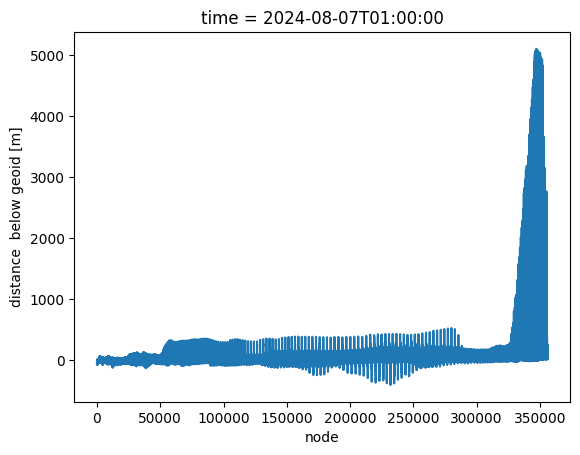

In [15]:
ds_subset_cwl.isel(time=0).depth.plot()